# Implementation of the DCGAN paper in tf+keras

Paper: https://arxiv.org/pdf/1511.06434.pdf

Please note that the slides here are taken directly from cs231n: http://cs231n.stanford.edu/.
I really hope this is not some weird license violation :/

### Architecture

1. Build a generator network in keras. This model will only be used to create fake images and never directly trained.

2. Build a discriminator network in keras. This model will be trained using fake labels from the generator and positive labels from the actual data.
    * Note: Soumith Chintala (one of the authors of the DCGAN paper) suggests feeding in homogeneous data points in a mini batch while training the discriminator, that is either all fake or all real.
    * We might want to also want to keep a pool of fake images from previous minibatches and stochastically feeding into the training. The hope is to prevent `mode collapse` where we always produce the same fake image or oscillate between outputs.

3. Make a GAN model which takes the noise input and spits out the discriminator output. That is GAN = D(G(Z)). In this composite model we make the discriminator weights non trainable. The idea is to use the gradients from the loss of the composite model to flow to the input of the discriminator (generator output). Now we can modify the weights of the Generator so that the discriminator would have predicted more true labels (`1`).

In [3]:
%matplotlib inline

In [159]:
from __future__ import division
from __future__ import unicode_literals

import tensorflow as tf

import logging
import random
import numpy as np
import datetime

import json
import pandas as pd

import keras
import keras.layers.core as kcore

from keras import optimizers

from keras.layers import normalization
from keras.layers import convolutional
from keras.layers import pooling
from keras.layers.core import Flatten
from keras_diagram import ascii

from keras.layers import Input, Embedding, LSTM, Dense, merge
from keras.models import Model
from keras.models import Sequential 
from keras.layers import Dense, Activation
from keras.layers import advanced_activations
from keras.regularizers import l1, l2, activity_l2
from keras.layers.core import Dropout
from IPython.display import display, HTML 


from sklearn import metrics as skmetrics

import cPickle as pickle

import IPython.display

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

pd.options.display.max_columns = 40
css = open('/nail/home/visp/ipython/style-table.css').read()
HTML('<style>{}</style>'.format(css))

In [5]:
import cv2
import os
from collections import namedtuple
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

from os.path import join as path_join
plt.style.use('seaborn-darkgrid')

Ensure that we are using `tf` dim ordering which is `(n_rows, n_cols, n_channels)`

In [6]:
cat ~/.keras/keras.json

{
    "image_dim_ordering": "tf", 
    "epsilon": 1e-07, 
    "floatx": "float32", 
    "backend": "tensorflow"
}

In [7]:
root_path = '/Users/visp/work/tutorials/tf_tutorials/GAN/'

In [8]:
celeb_path = path_join(root_path, 'data/celebA/')

In [9]:
Config = namedtuple(
    'Config',
    'num_samples output_size img_path '
    'mean_image_path transformed_img_path '
)
config = Config(
    num_samples=10000,
    output_size=(64, 64),
    img_path=celeb_path,
    mean_image_path=path_join(root_path, 'mean_img.npz'),
    transformed_img_path=path_join(root_path, 'transf_img.pkl'),
)


ImgData = namedtuple('ImgData', 'name img')

In [10]:
def plot_images(images):
    plt.figure(figsize=(15,8))
    n_rows = 2
    n_cols = 5
    for i in xrange(n_rows):
        for j in xrange(n_cols):
            idx = (i*n_cols) + j + 1
            plt.subplot(n_rows, n_cols, idx)
            plt.imshow(images[idx].img)
            plt.grid(False)

# Preprocessing and saving the preprocess
## (Only do for the first time)

## Loading and visualizing data

In [ ]:
%%bash
ls ~/work/tutorials/tf_tutorials/GAN/data/celebA/ | wc -l
ls ~/work/tutorials/tf_tutorials/GAN/data/celebA/ | head -5

### Load a few examples

In [ ]:
def load_input(dir_path, output_size, num_samples=None):
    raw_images = []
    for i, fl in enumerate(os.listdir(celeb_path)):
        if num_samples and i == num_samples:
            break
        raw_images.append(
            ImgData(
                name=fl,
                img=cv2.resize(
                    mpimg.imread(os.path.join(celeb_path, fl)),
                    output_size,
                ),
            ),
        )
    return raw_images

In [ ]:
raw_images = load_input(
    dir_path=config.img_path,
    num_samples=config.num_samples,
    output_size=config.output_size,
)

#### Plot some images

In [ ]:
plot_images(raw_images)

In [ ]:
raw_images[0].img.shape

## Preprocess image

### Compute mean image

In [ ]:
mean_image = np.zeros(
    [
        config.output_size[0],
        config.output_size[1],
        3, # num channels
    ],
    dtype=np.float32,
)
print mean_image.shape

In [ ]:
for rim in raw_images:
    mean_image += rim.img

mean_image /= config.num_samples

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(mean_image.astype(np.uint8))

In [ ]:
np.savez(
    file=config.mean_image_path,
    mean_image=mean_image,
)

# Load image and mean center

Mean center the images and map the output to a space of (-1, 1)

In [ ]:
def center_images(img, mean_image):
    """
    
    Deletes the mean image. And then scales the image
    so that (-255, 255) -> (-1, 1).
    """
    transf_img = img.astype(np.float32)
    transf_img -= mean_image
    x1, y1, x2, y2 = -255., -1., 255., 1.
    m = (y2 - y1) / (x2 - x1)
    return (m * (transf_img - x1) + y1)

In [ ]:
raw_images = load_input(
    dir_path=config.img_path,
    num_samples=config.num_samples,
    output_size=config.output_size,
)
mean_image = np.load(config.mean_image_path)['mean_image']

In [ ]:
plt.imshow(mean_image.astype(np.uint8))

In [ ]:
# plot_images(raw_images)

In [ ]:
transf_images = [
    ImgData(
        name=rim.name,
        img=center_images(img=rim.img, mean_image=mean_image),
    )
    for rim in raw_images
]

In [ ]:
# Find the min and the max value over all images
min_pix, max_pix = np.inf, -np.inf
for imd in transf_images:
    img_lin = imd.img[:]
    img_min, img_max = img_lin.min(), img_lin.max()
    if img_min < min_pix:
        min_pix = img_min
    if img_max > max_pix:
        max_pix = img_max

print 'min of all transformed pixels:', min_pix
print 'max of all transformed pixels:', max_pix

In [ ]:
plot_images(images=transf_images)

#### Save transformed image data (optional)

In [ ]:
# with open(config.transformed_img_path, 'w') as outfile:
#     pickle.dump(
#         obj=[
#             imd._asdict()
#             for imd in transf_images
#         ],
#         file=outfile,
#     )

# Model building

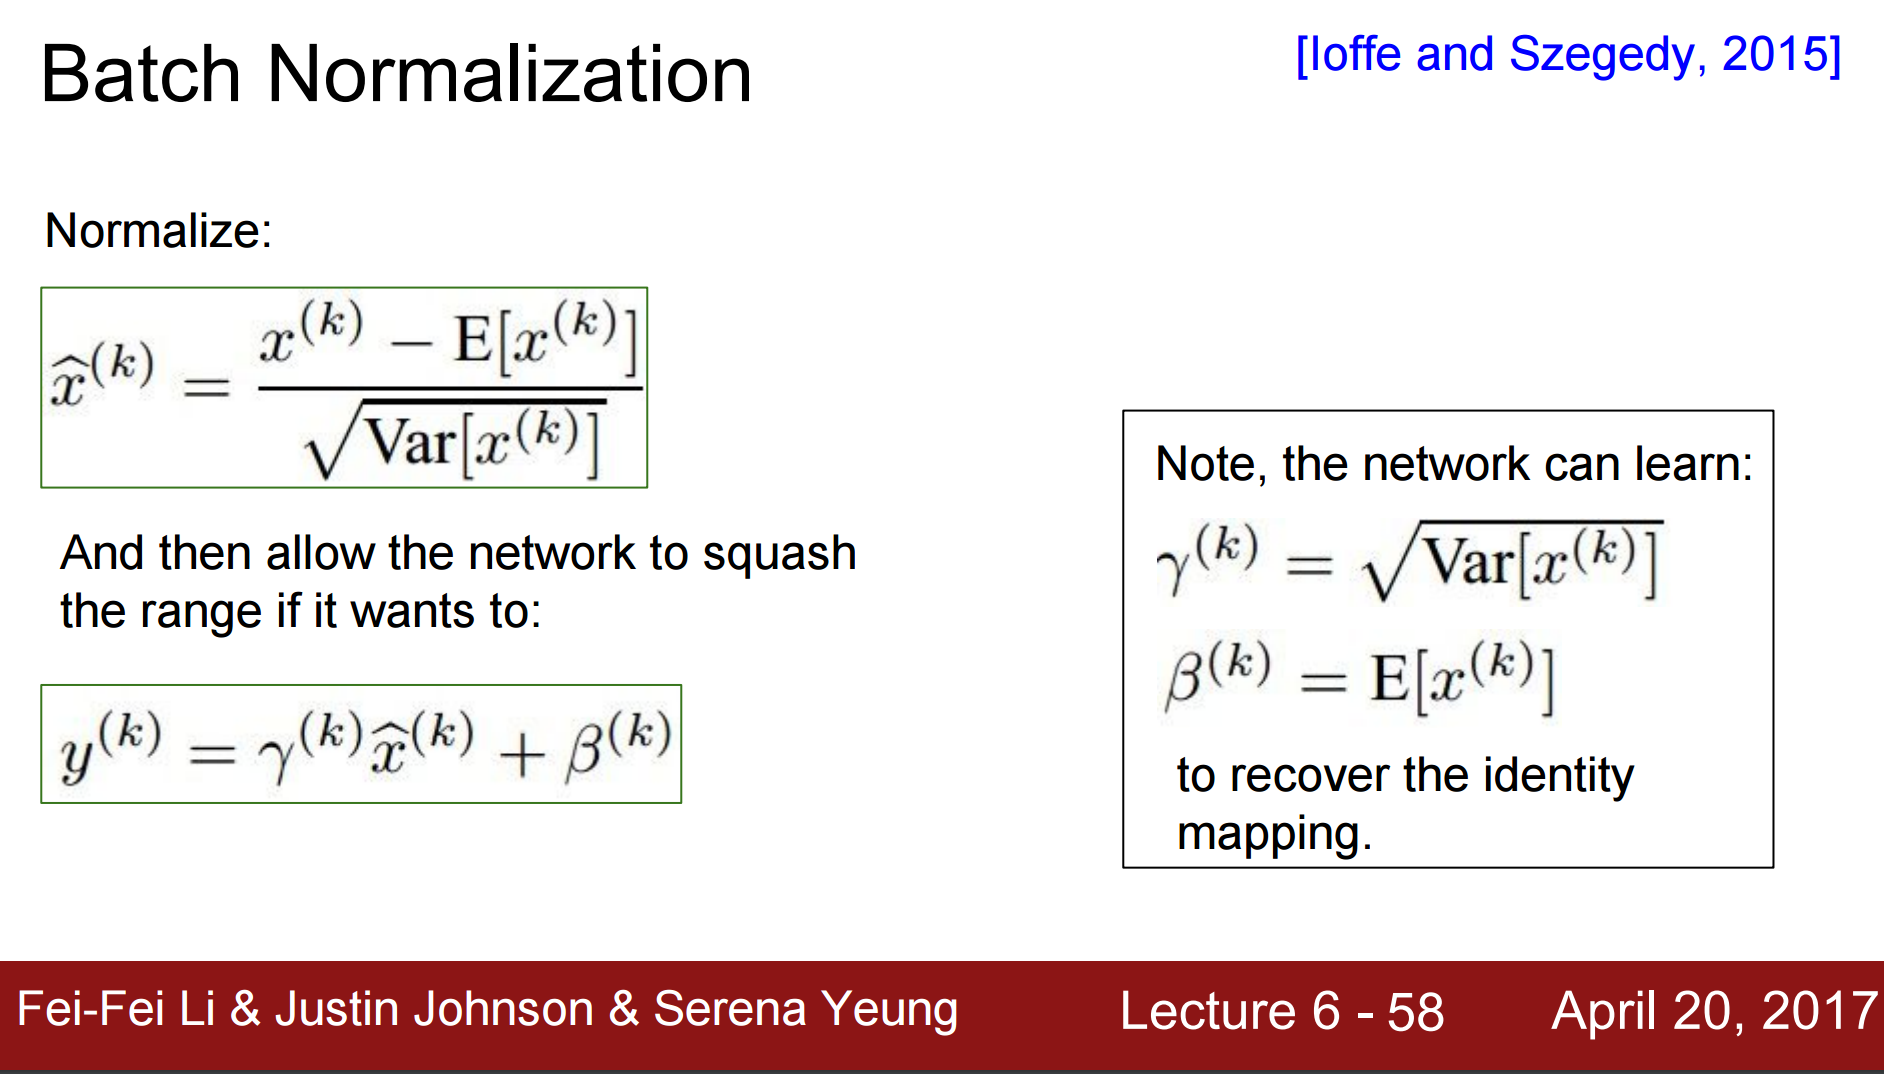

In [278]:
IPython.display.Image(path_join(root_path, 'batch_norm.png'))

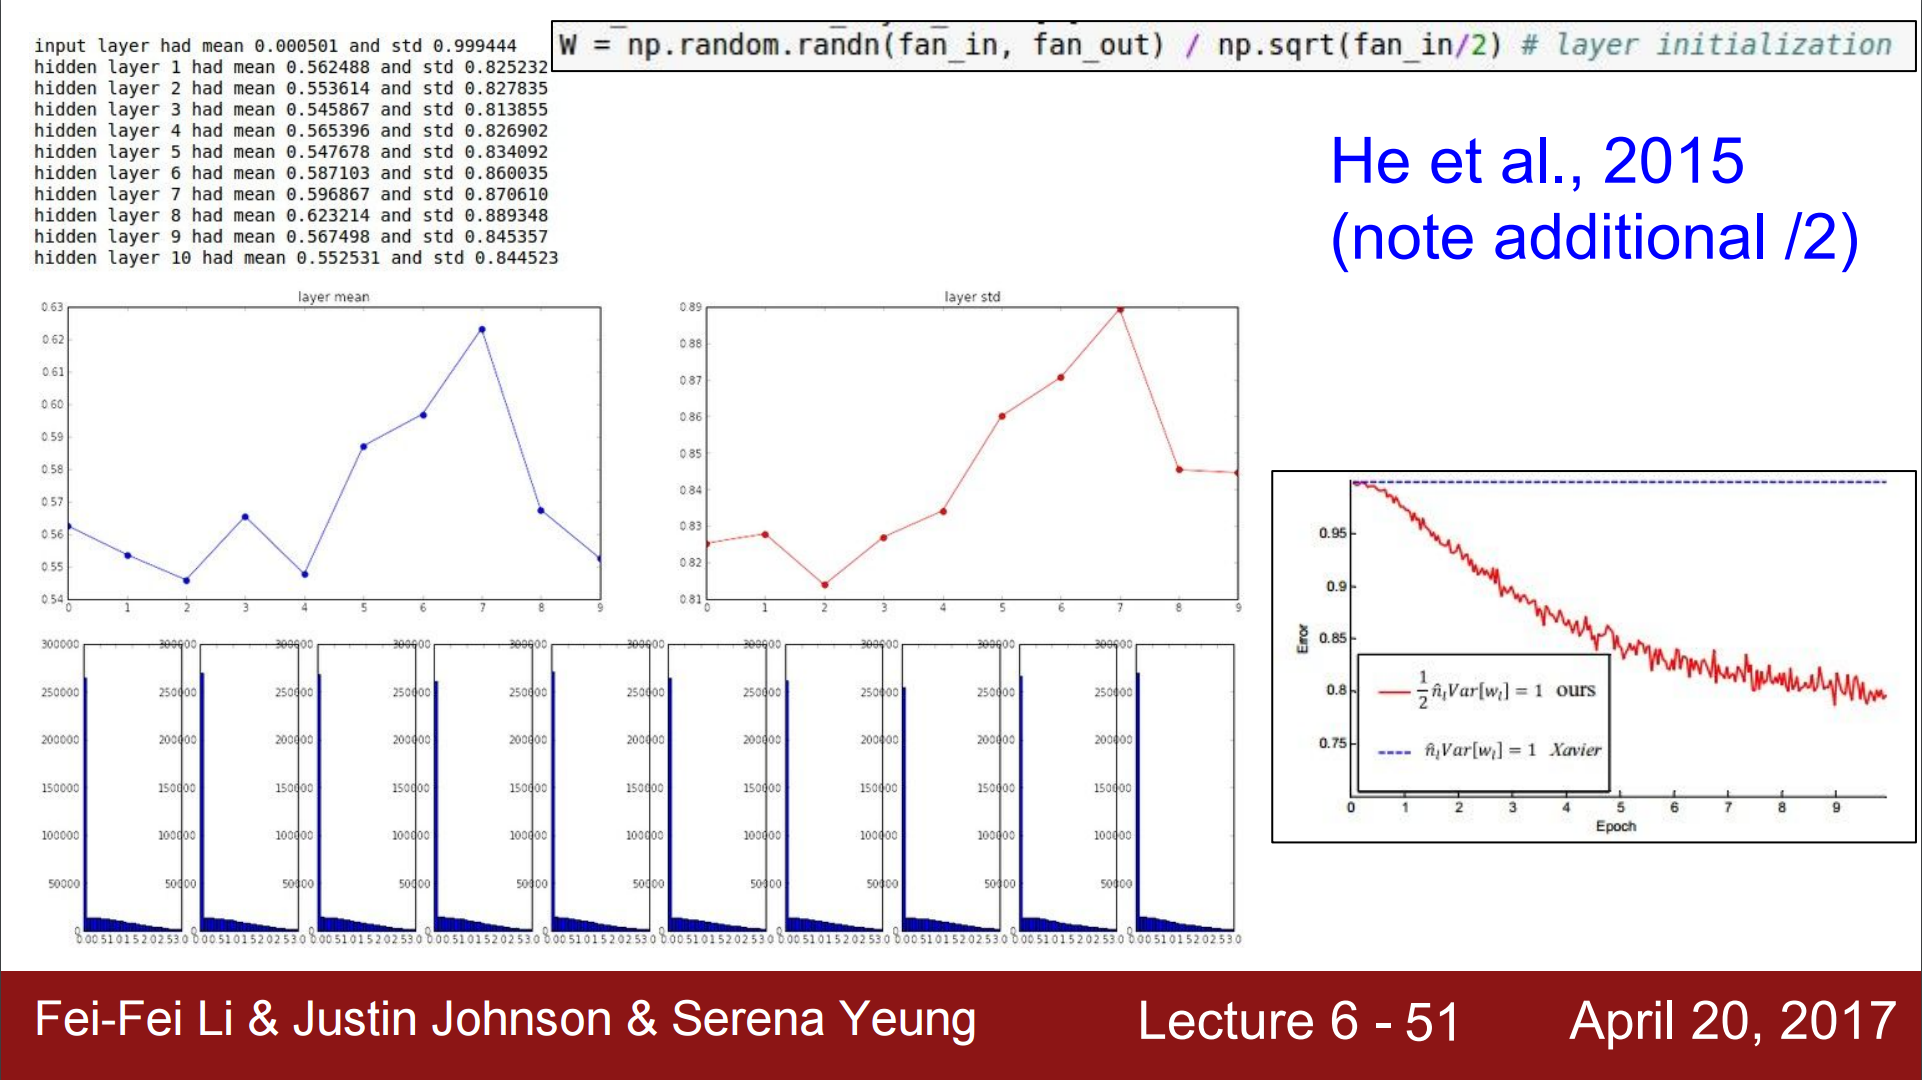

In [279]:
IPython.display.Image(path_join(root_path, 'he_activation.png'))

#### Load transformed image data (optional)

In [11]:
with open(config.transformed_img_path) as infile:
    transf_image_loaded = pickle.load(infile)
    transf_images = [
        ImgData(**each_loaded)
        for each_loaded in transf_image_loaded
    ]

## Optimizer

In [72]:
adam_opt = optimizers.Adam(
    lr=0.0002,
    beta_1=0.5,
    beta_2=0.999,
    epsilon=1e-08,
    decay=0.0,
)

## Generator

In [73]:
GENERATOR_Z_DIM = 100
GENERATOR_L1_DIM = (4, 4, 1024)

In [74]:
KernelSize = namedtuple('KernelSize', 'n_rows n_cols')

DEFAULT_KERNEL = KernelSize(
    n_rows=5,
    n_cols=5,
)

In [107]:
def activated_convt_layer(
        input_layer, n_rows_out, n_cols_out, nb_filter,
        name_suffix='', kernel_size=DEFAULT_KERNEL):
    convt = convt_layer(
        input_layer=input_layer,
        n_rows_out=n_rows_out,
        n_cols_out=n_cols_out,
        nb_filter=nb_filter,
        name_suffix=name_suffix,
        kernel_size=DEFAULT_KERNEL,
        # See the image above on why we use he_normal.
        # Since we are using batch norm, this is not very
        # important.
        kernel_init='he_normal',
    )
    # Batchnormalization with momentum update for the gradients.
    # The batch norm's \gamma initialized to 1 and \beta initialized
    # to zeros.
    # See also https://keras.io/layers/normalization/#batchnormalization
    convt_bn = normalization.BatchNormalization(
        axis=3,
        name='convt_bn_' + name_suffix,
    )(convt)
    return Activation(
        activation='relu',
        name='convt_act_' + name_suffix,
    )(convt_bn)


def convt_layer(
        input_layer, n_rows_out, n_cols_out, nb_filter,
        name_suffix, kernel_init='he_normal',
        kernel_size=DEFAULT_KERNEL):
    return convolutional.Deconvolution2D(
        nb_filter=nb_filter,
        nb_row=kernel_size.n_rows,
        nb_col=kernel_size.n_cols,
        output_shape=(None, n_rows_out, n_cols_out, nb_filter),
        border_mode='same',
        subsample=(2, 2),
        name='convt_' + name_suffix,
        init=kernel_init,
    )(input_layer)

In [108]:
l1_dim = GENERATOR_L1_DIM

z = Input(shape=(GENERATOR_Z_DIM,), dtype='float32', name='Z')
z_large = Dense(
    output_dim=(l1_dim[0]*l1_dim[1]*l1_dim[2]),
    name='G_Z_large',
)(z)
z_img_reshaped = kcore.Reshape(
    target_shape=l1_dim,
    name='G_Z_img_reshaped',
)(z_large)

convt_8_act = activated_convt_layer(
    input_layer=z_img_reshaped,
    n_rows_out=8,
    n_cols_out=8,
    nb_filter=512,
    name_suffix='G_4_to_8',
    kernel_size=KernelSize(
        n_rows=2,
        n_cols=2,
    ),
)
convt_16_act = activated_convt_layer(
    input_layer=convt_8_act,
    n_rows_out=16,
    n_cols_out=16,
    nb_filter=256,
    name_suffix='G_8_to_16',
)
convt_32_act = activated_convt_layer(
    input_layer=convt_16_act,
    n_rows_out=32,
    n_cols_out=32,
    nb_filter=128,
    name_suffix='G_16_to_32',
)
# Note that this is not an activated layer
# We want the last layer to be a convolution with
# a tanh activation and no batch normalization.
# Refer to the DCGAN paper.
convt_64 = convt_layer(
    input_layer=convt_32_act,
    n_rows_out=64,
    n_cols_out=64,
    nb_filter=3,
    name_suffix='G_32_to_64',
    kernel_init='glorot_normal',
)
gan_image = Activation(activation='tanh', name='G_gan_image')(convt_64)
generator = Model(
    input=z,
    output=gan_image,
    name='generator',
)
generator.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt,
)

In [109]:
print ascii(generator)

          InputLayer (None, 100)         
               Dense (None, 16384)       
             Reshape (None, 4, 4, 1024)  
     Deconvolution2D (None, 8, 8, 512)   
  BatchNormalization (None, 8, 8, 512)   
                Relu (None, 8, 8, 512)   
     Deconvolution2D (None, 16, 16, 256) 
  BatchNormalization (None, 16, 16, 256) 
                Relu (None, 16, 16, 256) 
     Deconvolution2D (None, 32, 32, 128) 
  BatchNormalization (None, 32, 32, 128) 
                Relu (None, 32, 32, 128) 
     Deconvolution2D (None, 64, 64, 3)   
                Tanh (None, 64, 64, 3)   



In [110]:
generator.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Z (InputLayer)                   (None, 100)           0                                            
____________________________________________________________________________________________________
G_Z_large (Dense)                (None, 16384)         1654784     Z[0][0]                          
____________________________________________________________________________________________________
G_Z_img_reshaped (Reshape)       (None, 4, 4, 1024)    0           G_Z_large[0][0]                  
____________________________________________________________________________________________________
convt_G_4_to_8 (Deconvolution2D) (None, 8, 8, 512)     13107712    G_Z_img_reshaped[0][0]           
___________________________________________________________________________________________

## Discriminator

In [218]:
def activated_conv_layer(
        input_layer, n_rows_out, n_cols_out, nb_filter,
        name_suffix='', kernel_size=DEFAULT_KERNEL):
    conv = conv_layer(
        input_layer=input_layer,
        n_rows_out=n_rows_out,
        n_cols_out=n_cols_out,
        nb_filter=nb_filter,
        name_suffix=name_suffix,
        kernel_size=DEFAULT_KERNEL,
        # See the image above on why we use he_normal.
        # Since we are using batch norm, this is not very
        # important.
        kernel_init='he_normal',
    )
    # Batchnormalization with momentum update for the gradients.
    # The batch norm's \gamma initialized to 1 and \beta initialized
    # to zeros.
    # See also https://keras.io/layers/normalization/#batchnormalization
    # We have to use mode=2 for model sharing. See
    # https://github.com/fchollet/keras/issues/2827 why.
    conv_bn = normalization.BatchNormalization(
        axis=3,
        mode=2,
        name='conv_bn_' + name_suffix,
    )(conv)
    return advanced_activations.LeakyReLU(alpha=0.2)(conv_bn)


def conv_layer(
        input_layer, n_rows_out, n_cols_out, nb_filter,
        name_suffix, kernel_init='he_normal',
        kernel_size=DEFAULT_KERNEL):
    return convolutional.Convolution2D(
        nb_filter=nb_filter,
        nb_row=kernel_size.n_rows,
        nb_col=kernel_size.n_cols,
        border_mode='same',
        subsample=(2, 2),
        name='conv_' + name_suffix,
        init=kernel_init,
    )(input_layer)

In [219]:
d_input_img = Input(shape=(64, 64, 3), dtype='float32', name='D_input_img')

conv_32_act = activated_conv_layer(
    input_layer=d_input_img,
    n_rows_out=32,
    n_cols_out=32,
    nb_filter=128,
    name_suffix='D_64_to_32',
)
conv_16_act = activated_conv_layer(
    input_layer=conv_32_act,
    n_rows_out=16,
    n_cols_out=16,
    nb_filter=256,
    name_suffix='D_32_to_16',
)
conv_8_act = activated_conv_layer(
    input_layer=conv_16_act,
    n_rows_out=8,
    n_cols_out=8,
    nb_filter=512,
    name_suffix='D_16_to_8',
)
last_conv_flat = Flatten(name='D_last_conv_flat')(conv_8_act)
d_pred = Dense(1, activation='sigmoid', name='D_pred')(last_conv_flat)
discriminator = Model(input=d_input_img, output=d_pred)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt,
    name='discriminator',
)
print ascii(discriminator)
discriminator.summary()

          InputLayer (None, 64, 64, 3)   
       Convolution2D (None, 32, 32, 128) 
  BatchNormalization (None, 32, 32, 128) 
           LeakyReLU (None, 32, 32, 128) 
       Convolution2D (None, 16, 16, 256) 
  BatchNormalization (None, 16, 16, 256) 
           LeakyReLU (None, 16, 16, 256) 
       Convolution2D (None, 8, 8, 512)   
  BatchNormalization (None, 8, 8, 512)   
           LeakyReLU (None, 8, 8, 512)   
             Flatten (None, 32768)       
               Dense (None, 1)           

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
D_input_img (InputLayer)         (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
conv_D_64_to_32 (Convolution2D)  (None, 32, 32, 128)   9728        D_input_img[0][0]       

## GAN: Composite model to train G

In [220]:
def make_trainable(model, is_trainable):
    """Makes a model (not) trainable.
  
    .. note::
  
        This mutates the model in place.
    """
    model.trainable = is_trainable
    for layer in model.layers:
        layer.trainable = is_trainable

In [221]:
make_trainable(model=discriminator, is_trainable=False)
gan_input_z = Input(shape=(GENERATOR_Z_DIM,), dtype='float32', name='gan_Z')
generator_img_out = generator(gan_input_z)
# We want the discriminator to predict all true for the fake
# labels here. Remember this networks sole purpose is to train
# the Generator.
disc_pred_for_fake = discriminator(generator_img_out)
gan_composite = Model(input=gan_input_z, output=disc_pred_for_fake)
gan_composite.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt,
    name='gan_composite',
)
print ascii(gan_composite)
gan_composite.summary()

          InputLayer (None, 100)         
               Dense (None, 16384)       
             Reshape (None, 4, 4, 1024)  
     Deconvolution2D (None, 8, 8, 512)   
  BatchNormalization (None, 8, 8, 512)   
                Relu (None, 8, 8, 512)   
     Deconvolution2D (None, 16, 16, 256) 
  BatchNormalization (None, 16, 16, 256) 
                Relu (None, 16, 16, 256) 
     Deconvolution2D (None, 32, 32, 128) 
  BatchNormalization (None, 32, 32, 128) 
                Relu (None, 32, 32, 128) 
     Deconvolution2D (None, 64, 64, 3)   
                Tanh (None, 64, 64, 3)   
               Model (None, 1)           

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
gan_Z (InputLayer)               (None, 100)           0                                            
__________________________________________________________________

# Model training

In [222]:
# keras.callbacks.TensorBoard

## Util functions

- Function to create noise input for the generator.
- Function to create fake_images from the generator.

In [244]:
def generate_z(n_samples, z_dim=100):
    return np.random.uniform(0, 1, size=[n_samples, z_dim])

    
def generate_fake_images(generator, n_samples, z_dim=100):
    return generator.predict(
        generate_z(n_samples, z_dim),
        batch_size=250,
        verbose=1,
    )

## Pretrain the discriminator

In [245]:
HOMOGENEOUS = False

In [271]:
def iter_disc_minibatch(generator, real_images, batch_size, n_batches=2):
    """Produces discriminator training data.
    
    :param real_images:
    :type real_images: ImgData
    
    n_batches must be even because we pass
    in only homogeneous data in each mini batch. That
    is either all fake or all real. Sice we want equal
    num of each, n_batches needs to be even.
    """
    if n_batches % 2 != 0:
        raise ValueError('n_batches must be even but is %d', n_batches)
    
    real_images = [rid.img for rid in real_images]
    random.shuffle(real_images)
    for i in xrange(n_batches):
        if i % 2 == 0:
            x_batch = generate_fake_images(
                generator=generator,
                n_samples=batch_size,
            )
            yield (np.array(x_batch), [0.]*len(x_batch))
        else:
            j = i//2
            x_batch = real_images[j*batch_size:(j+1)*batch_size]
            yield (np.array(x_batch), [1.]*len(x_batch))

def iter_disc_minibatch_mix(generator, real_images, batch_size, n_batches=2):
    """Produces discriminator training data.
    
    :param real_images:
    :type real_images: ImgData
    """
    real_images = [rid.img for rid in real_images]
    random.shuffle(real_images)
    half_batch = batch_size//2
    rem_batch = batch_size-half_batch
    for i in xrange(n_batches):
        x_fake = generate_fake_images(
            generator=generator,
            n_samples=half_batch,
        )
        x_real = real_images[i*rem_batch:(i+1)*rem_batch]
        x_batch = x_fake+x_real
        y_batch = [0.]*half_batch + [1.]*rem_batch
        batch_data = zip(x_batch, y_batch)
        random.shuffle(batch_data)
        x_batch_shuf, y_batch_shuf = zip(*batch_data)
        yield (np.array(x_batch_shuf), list(y_batch_shuf))
        
def disc_all_data(generator, real_images, n_samples=None):
    if n_samples:
        real_images = real_images[:n_samples//2]
    
    real_images = [rid.img for rid in real_images]
    n_samples = len(real_images)
    x_fake = generate_fake_images(
        generator=generator,
        n_samples=n_samples,
    ).tolist()
    x = x_fake+real_images
    y = [0.]*n_samples + [1.]*n_samples
    data = zip(x, y)
    random.shuffle(data)
    x_shuf, y_shuf = zip(*data)
    return (np.array(x_shuf), list(y_shuf))

In [263]:
TrainConfig = namedtuple(
    'TrainConfig',
    (
        'batch_size '
        'd_pretrain_n_batches '
        'd_pretrain_n_epoch'
    ),
)
train_config = TrainConfig(
    batch_size=126,
    d_pretrain_n_batches=10,
    d_pretrain_n_epoch=1,
)

d_initial_epoch = 0

In [264]:
make_trainable(discriminator, True)

In [ ]:
if HOMOGENEOUS:
    for i in xrange(train_config.d_pretrain_n_epoch):
        for j, batch_data in enumerate(
            iter_disc_minibatch_mix(
                generator=generator,
                real_images=transf_images,
                batch_size=train_config.batch_size,
                n_batches=train_config.d_pretrain_n_batches,
            )
        ):
            if j %10==0:
                print j, '/', train_config.d_pretrain_n_batches
            discriminator.fit(
                x=batch_data[0],
                y=batch_data[1],
                batch_size=train_config.batch_size,
                nb_epoch=1,
                verbose=0,
                callbacks=None,
                validation_split=0.2,
                initial_epoch=d_initial_epoch
            )
            d_initial_epoch += 1
else:
    d_train_data = disc_all_data(
        generator=generator,
        real_images=transf_images,
        n_samples=5000,
    )
    print 'generated data'
    discriminator.fit(
        x=d_train_data[0],
        y=d_train_data[1],
        batch_size=train_config.batch_size,
        nb_epoch=5,
        verbose=1,
        callbacks=None,
        validation_split=0.2,
        initial_epoch=0
    )

#### Test the pretrained disc

In [273]:
X_d_val, Y_d_val = disc_all_data(generator, transf_images, n_samples=1000)
pred_d_val = discriminator.predict(X_d_val).ravel()
print skmetrics.accuracy_score(y_true=Y_d_val, y_pred=(pred_d_val>0.5))

500/500 [==============================] - 14s    
1.0


In [277]:
pd.Series(pred_d_val).describe()

count    1.000000e+03
mean     5.000914e-01
std      5.001158e-01
min      8.405703e-07
25%      1.914216e-05
50%      4.961875e-01
75%      1.000000e+00
max      1.000000e+00
dtype: float64